In [116]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from collections import Counter
import re

In [2]:
# Repeat using deSeq to look at the log fold change in the functions 

In [117]:
pd.read_csv('../../Susie Data/chemotaxis_readcounts_withnicknames.csv', index_col=0)

Function_nickname   \
Function                                                                                                
Aerotaxis_sensor_receptor_protein                                   Aerotaxis sensor receptor protein   
Chemotaxis_protein_CheC_--_inhibitor_of_MCP_met...                                               CheC   
Chemotaxis_protein_CheD                                                                          CheD   
Chemotaxis_protein_CheV_(EC_2.7.3.-)                                                             CheV   
Chemotaxis_protein_CheX                                                                          CheX   
Chemotaxis_protein_methyltransferase_CheR_(EC_2...                                               CheR   
Chemotaxis_regulator_-_transmits_chemoreceptor_...                                               CheY   
Chemotaxis_response_-_phosphatase_CheZ                                                           CheZ   
Chemotaxis_response_regulator_protein-glutamate...                                               CheB   
Dipeptide-binding_ABC_transporter,_periplasmic_...   ABC transporter periplasmic substrate-binding...   
Dipeptide-binding_ABC_transporter,_periplasmic_...  Dipeptide-binding ABC transporter, periplasmic...   
Dipeptide-binding_ABC_transporter,_periplasmic_...                                  Dipeptide binding   
Flagellar_motor_switch_protein_FliG                                                              FliG   
Flagellar_motor_switch_protein_FliM                                                              FliM   
Flagellar_motor_switch_protein_FliN                                                              FliN   
Galactose/methyl_galactoside_ABC_transport_syst...                                               MglB   
Maltodextrin_ABC_transporter,_substrate-binding...                                               MdxE   
Maltose/maltodextrin_ABC_transporter,_substrate...                                               MalE   
Methyl-accepting_chemotaxis_protein_III_(ribose...                                            MCP III   
Methyl-accepting_chemotaxis_protein_II_(asparta...                                            MCP II    
Methyl-accepting_chemotaxis_protein_IV_(dipepti...                                             MCP IV   
Methyl-accepting_chemotaxis_protein_I_(serine_c...                                              MCP I   
Methyl-accepting_chemotaxis_sensor/transducer_p...  Methyl-accepting chemotaxis sensor/transducer ...   
Methyl-accepting_chemotaxis_sensor_protein_STM3152  Methyl-accepting chemotaxis sensor protein STM...   
Methyl-accepting_chemotaxis_sensor_protein_STM3216  Methyl-accepting chemotaxis sensor protein STM...   
Oligopeptide_transport_substrate-binding_protei...                                               GsiB   
Positive_regulator_of_CheA_protein_activity_(CheW)                                               CheW   
Possible_tripeptide-binding_ABC_transporter,_pe...                                Tripeptide binding    
Ribose_ABC_transporter,_periplasmic_ribose-bind...                                               RbsB   
Signal_transduction_histidine_kinase_CheA_(EC_2...                                               CheA   
Methyl-accepting_chemotaxis_citrate_transducer         Methyl-accepting chemotaxis citrate transducer   
Ribose_ABC_transport_system,_periplasmic_ribose...                                               RbsB   
D,D-dipeptide-binding_periplasmic_protein_DdpA                                                   DdpA   
hypothetical_protein                                                             hypothetical protein   

                                                    FAME000001_good_out_R1.fastq %  \
Function                                                                             
Aerotaxis_sensor_receptor_protein                                         0.032448   
Chemotaxis_protein_CheC_--_inhibitor_of_MCP_

In [118]:
# imports 
chemotaxis = pd.read_csv('../../Susie Data/chemotaxis_readcounts_withnicknames.csv', index_col=0)
chemotaxis.columns = [i[:10] for i in chemotaxis.columns]
metadata = pd.read_csv('../../Susie Data/metadata.csv')
chemotaxis.index = chemotaxis['Function_n']
chemotaxis = chemotaxis.drop(['Function_n'], axis=1)

# drop rows that we don't want to include 
chemotaxis = chemotaxis.drop('hypothetical protein', axis=0)

# fill in the zeros 
# Calculate the percentage of NaN values across each row
nan_percentage = chemotaxis.isna().mean(axis=1)

# Filter rows where more than half of the values are NaN
threshold = 0.5
chemotaxis = chemotaxis[nan_percentage < threshold]

In [119]:
start_fame = metadata[metadata['location'] == 'start']['FAME']
end_fame = metadata[metadata['location'] == 'end']['FAME']

In [120]:
tube_dict = dict(zip(metadata['FAME'], metadata['tube']))
location_dict = dict(zip(metadata['FAME'], metadata['location']))


end_df = chemotaxis[end_fame].stack().reset_index()
end_df['location'] = ['end' for e in range(len(end_df))]  
end_df['tube'] = [tube_dict.get(i) for i in end_df['level_1']]


start_df = chemotaxis[start_fame].stack().reset_index()
start_df['location'] = ['start' for e in range(len(start_df))] 
start_df['tube'] = [tube_dict.get(i) for i in start_df['level_1']]

chemotaxis_stacked = pd.concat([end_df, start_df])


# add some transforms 
chemotaxis_stacked['log abundance'] = np.log(chemotaxis_stacked[0])



<Axes: xlabel='0', ylabel='Function_n'>

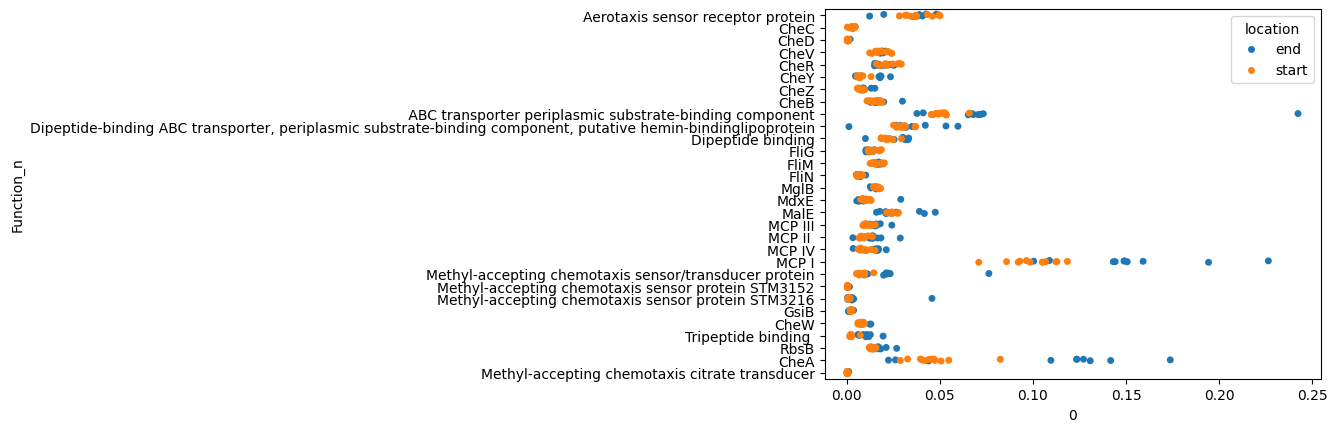

In [7]:
sns.stripplot(data=chemotaxis_stacked, y = 'Function_n', hue = 'location', x = 0)

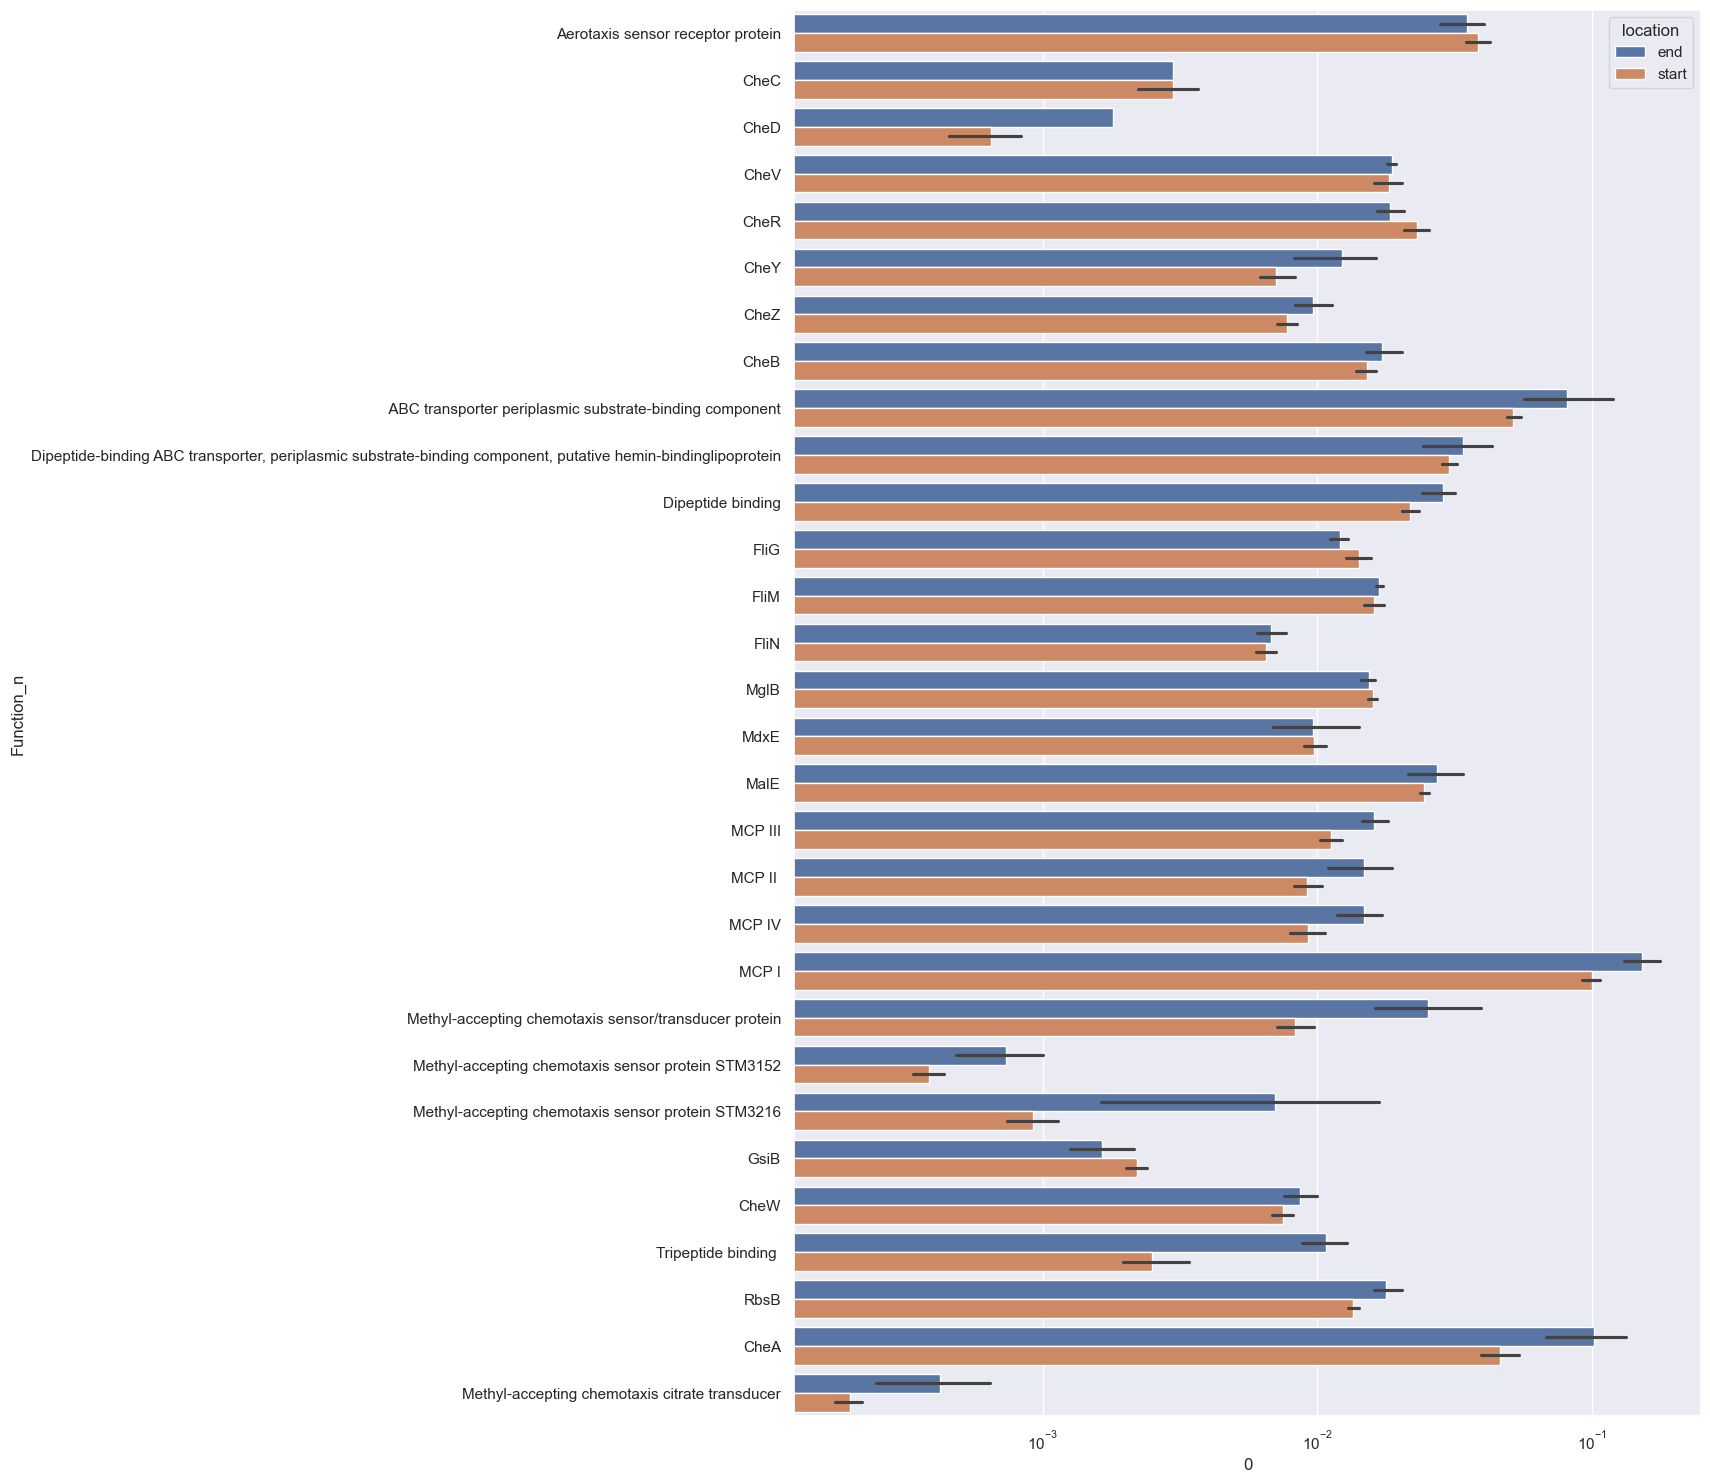

In [8]:
sns.set(rc={'figure.figsize':(11.7,18.27)})
sns.barplot(data=chemotaxis_stacked, y = 'Function_n', hue = 'location', x = 0)
plt.xscale('log')

### plot the difference in proportion as well 
Not sure if I should be computing the difference between them and then taking the mean or looking at the difference between the means

In [9]:
start_means = pd.DataFrame(start_df.groupby('Function_n')[0].mean())
end_means = pd.DataFrame(end_df.groupby('Function_n')[0].mean())

# difference in the mean proportion
mean_proportion = start_means - end_means 
mean_proportion = mean_proportion.sort_values(0)

<Axes: ylabel='Function_n'>

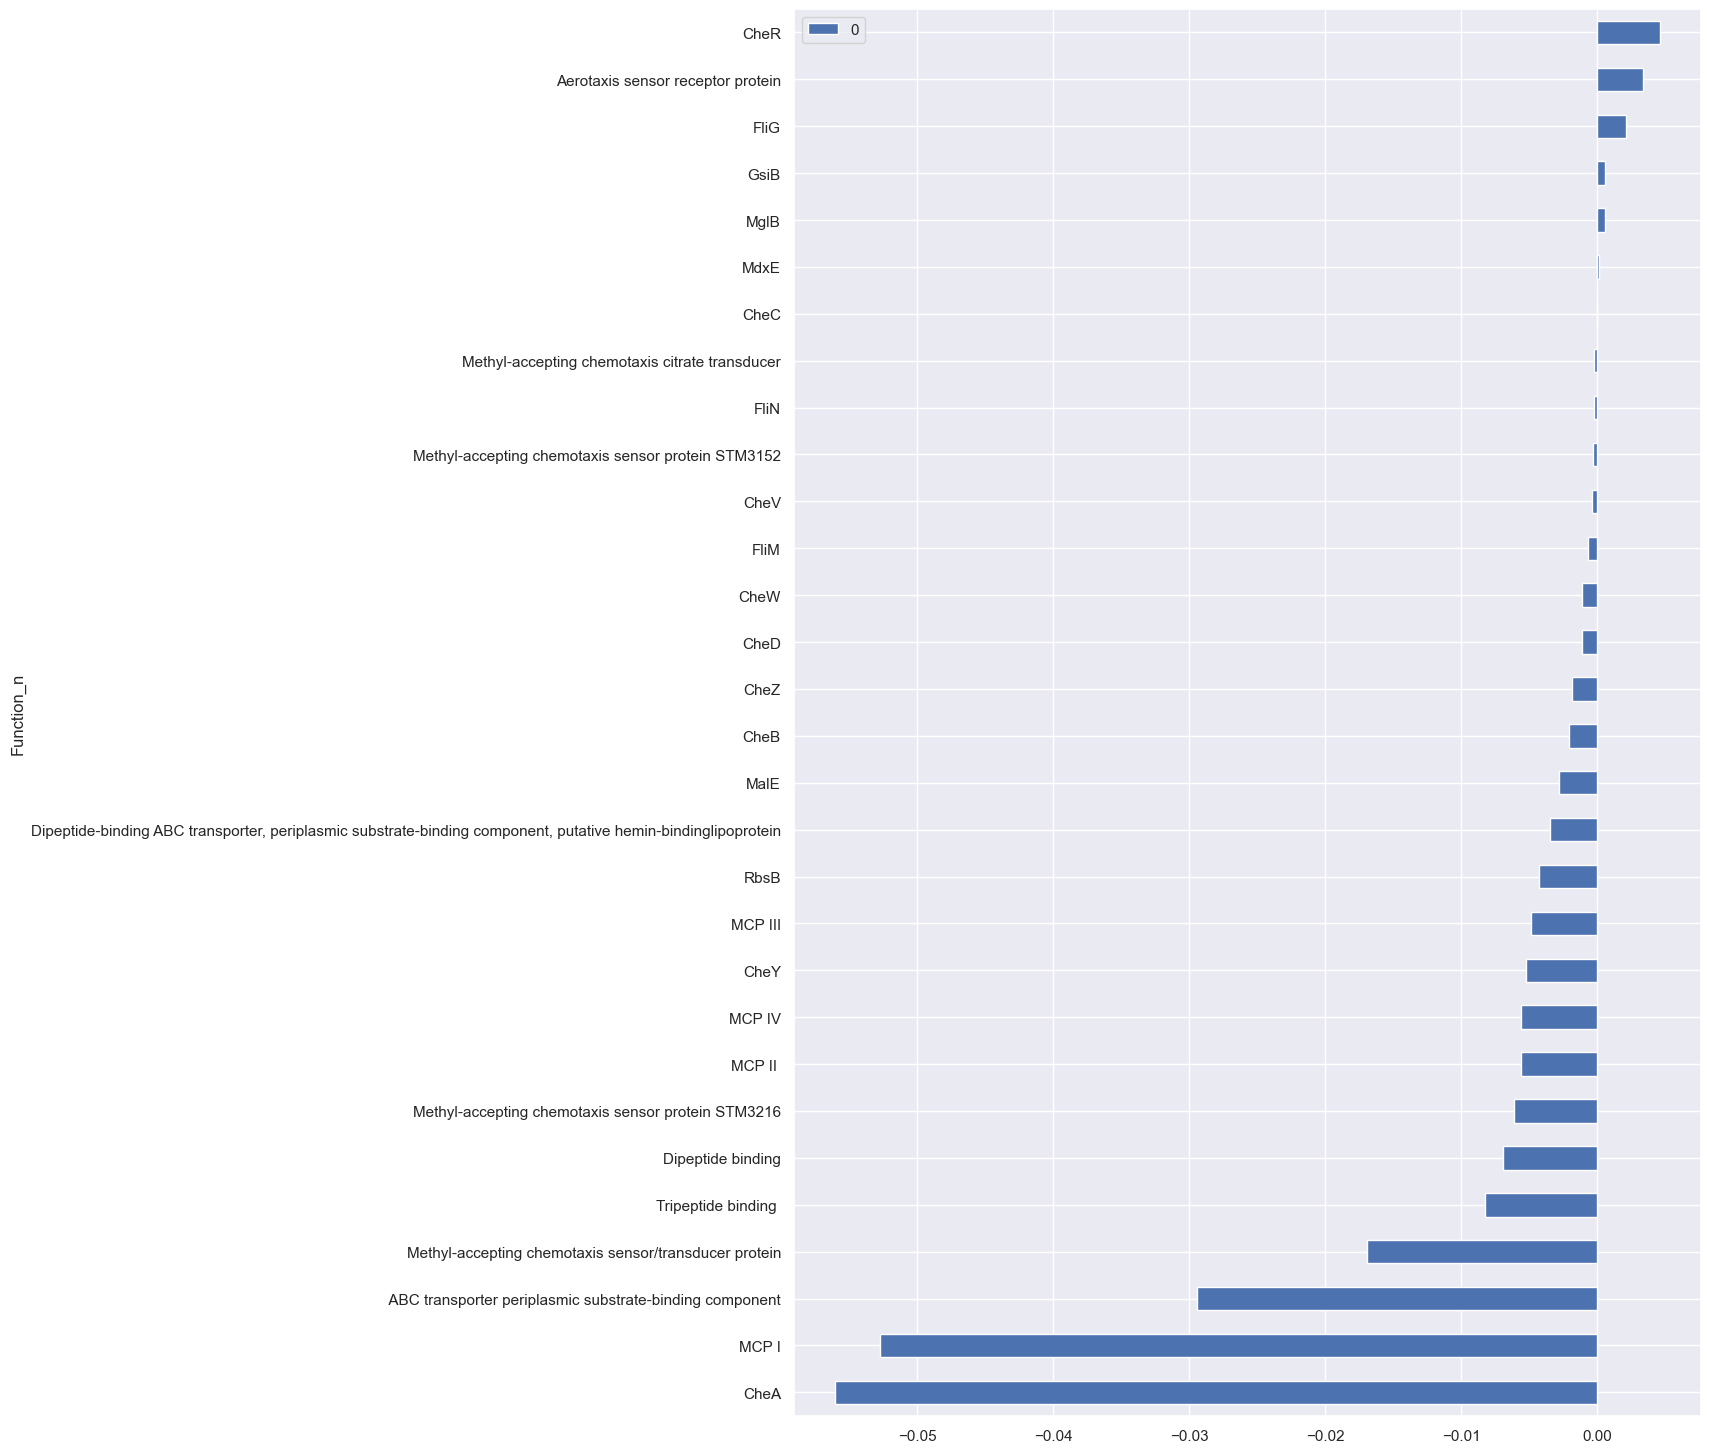

In [10]:
mean_proportion.plot(kind='barh')

### Compute the difference in mean proportion at the sample level

In [11]:
# need to add a column stating the replicate that the data has come from 

In [12]:
# could have the 95% confidence interval marked on this plot instead potentially 
start_end_merged =start_df.drop('location', axis=1).merge(end_df.drop('location', axis=1), how = 'outer', on = [ 'Function_n', 'tube' ],
                                                         suffixes = ['_start', '_end'],)
start_end_merged['diff'] = start_end_merged['0_end'] - start_end_merged['0_start']
start_end_merged['diff_abs'] = np.abs(start_end_merged['diff'])

# this line is incorrect - need to go back and adjust 
mean_diff = pd.DataFrame(start_end_merged.groupby('Function_n')['diff'].mean())
mean_diff['start_vs_end'] = [1 if i < 0 else 0 for i in mean_diff['diff']]
mean_diff_dict = dict(zip(mean_diff.index.to_list(), mean_diff['start_vs_end']))
start_end_merged['start_vs_end']  = [mean_diff_dict.get(i) for i in start_end_merged['Function_n'].to_list()]


In [13]:
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")


In [14]:
start_functions = chemotaxis[start_fame]
end_functions = chemotaxis[end_fame]
p_values = [] 
sig = []

for i in range(len(chemotaxis)): 
    #s, p = stats.kruskal(start_functions.iloc[i], end_functions.iloc[i])
    #s, p = stats.mannwhitneyu(start_functions.iloc[i], end_functions.iloc[i])  # this is essentially a Welch's t-test 
    s, p = stats.ttest_ind(start_functions.iloc[i], end_functions.iloc[i], equal_var = False)
    sig.append(s)
    p_values.append(p)

# assemble into a dataframe to investigate further 
mannwhitney_df = pd.DataFrame.from_dict({"Function": chemotaxis.index, 's': sig, 'p': p_values})

In [15]:
sig_functions = mannwhitney_df[mannwhitney_df['p'] < 0.05]

In [16]:
# then also run some stats tests to see how these changes 
mannwhitney_df.sort_values('p')

Function         s         p
26                                Tripeptide binding  -6.582119  0.000032
17                                            MCP III -4.223627  0.000805
20                                              MCP I -4.321720  0.001219
27                                               RbsB -3.602493  0.004455
19                                             MCP IV -3.298039  0.005604
28                                               CheA -3.295020  0.008085
10                                  Dipeptide binding -2.928314  0.012789
4                                                CheR  2.694480  0.013952
18                                            MCP II  -2.703694  0.021274
11                                               FliG  2.216612  0.040082
5                                                CheY -2.221994  0.050003
24                                               GsiB  2.086911  0.058917
6                                                CheZ -2.068678  0.060044
8    ABC transporter periplasmic substrate-binding... -1.594271  0.144890
7                                                CheB -1.239624  0.237296
12                                               FliM -0.930536  0.368658
14                                               MglB  0.921107  0.370077
0                   Aerotaxis sensor receptor protein  0.831714  0.418499
16                                               MalE -0.781924  0.453437
9   Dipeptide-binding ABC transporter, periplasmic... -0.681780  0.511241
13                                               FliN -0.461868  0.650222
3                                                CheV -0.311656  0.760107
15                                               MdxE  0.061952  0.951834
1                                                CheC       NaN       NaN
2                                                CheD       NaN       NaN
21  Methyl-accepting chemotaxis sensor/transducer ...       NaN       NaN
22  Methyl-accepting chemotaxis sensor protein STM...       NaN       NaN
23  Methyl-accepting chemotaxis sensor protein STM...       NaN       NaN
25                                               CheW       NaN       NaN
29     Methyl-accepting chemotaxis citrate transducer       NaN       NaN

In [17]:
chemotaxis_sig_functions = chemotaxis_stacked[chemotaxis_stacked['Function_n'].isin(sig_functions['Function'])]

/var/folders/df/d2hn3bdx7dj7syrpbrxgtzkw0000gn/T/ipykernel_6511/2459844656.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontstyle='italic')


[Text(0, 0, 'CheR'),
 Text(0, 1, 'Dipeptide binding'),
 Text(0, 2, 'FliG'),
 Text(0, 3, 'MCP III'),
 Text(0, 4, 'MCP II '),
 Text(0, 5, 'MCP IV'),
 Text(0, 6, 'MCP I'),
 Text(0, 7, 'Tripeptide binding '),
 Text(0, 8, 'RbsB'),
 Text(0, 9, 'CheA')]

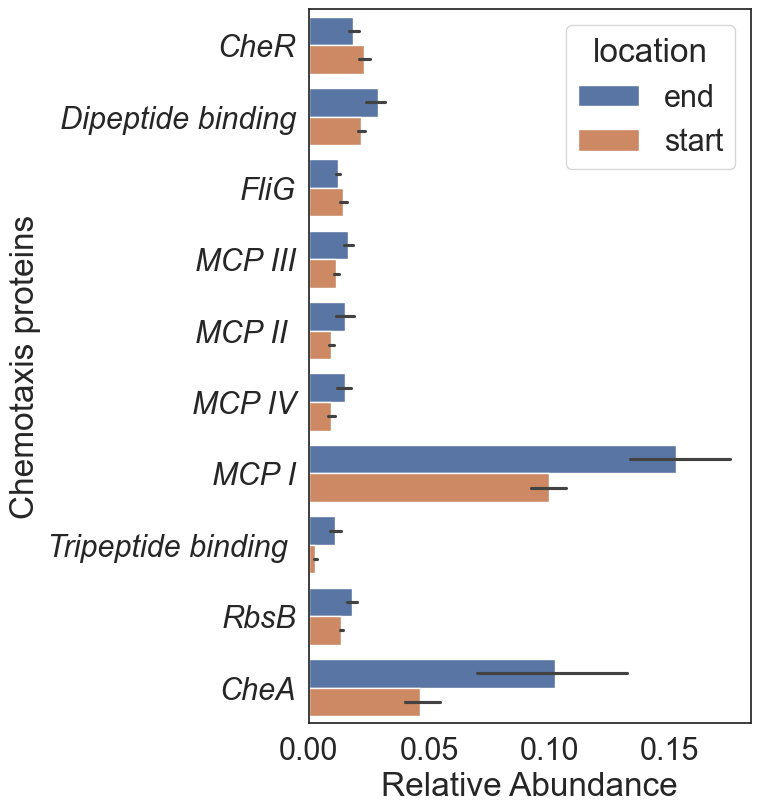

In [18]:
sns.set(rc={'figure.figsize':(5.7,9.27)}, font_scale=2, style = 'white')
ax = sns.barplot(data=chemotaxis_sig_functions, y = 'Function_n', hue = 'location', x = 0)
plt.xlabel('Relative Abundance')
plt.ylabel('Chemotaxis proteins')
# Set x tick labels to italic
ax.set_yticklabels(ax.get_yticklabels(), fontstyle='italic')

In [19]:
chemotaxis_sig_functions

Function_n     level_1         0 location tube  log abundance
22        CheR  FAME000002  0.014963      end   A1      -4.202165
23        CheR  FAME000004  0.018633      end   B1      -3.982802
24        CheR  FAME000006  0.020379      end   E1      -3.893263
25        CheR  FAME000009  0.017686      end   B2      -4.034967
26        CheR  FAME000011  0.023297      end   C2      -3.759423
..         ...         ...       ...      ...  ...            ...
341       CheA  FAME000014  0.046878    start   E2      -3.060203
342       CheA  FAME000016  0.050616    start   A3      -2.983495
343       CheA  FAME000018  0.047318    start   B3      -3.050874
344       CheA  FAME000020  0.045517    start   D3      -3.089678
345       CheA  FAME000022  0.039536    start   E3      -3.230545

[220 rows x 6 columns]

/var/folders/df/d2hn3bdx7dj7syrpbrxgtzkw0000gn/T/ipykernel_6511/2874896778.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontstyle='italic')


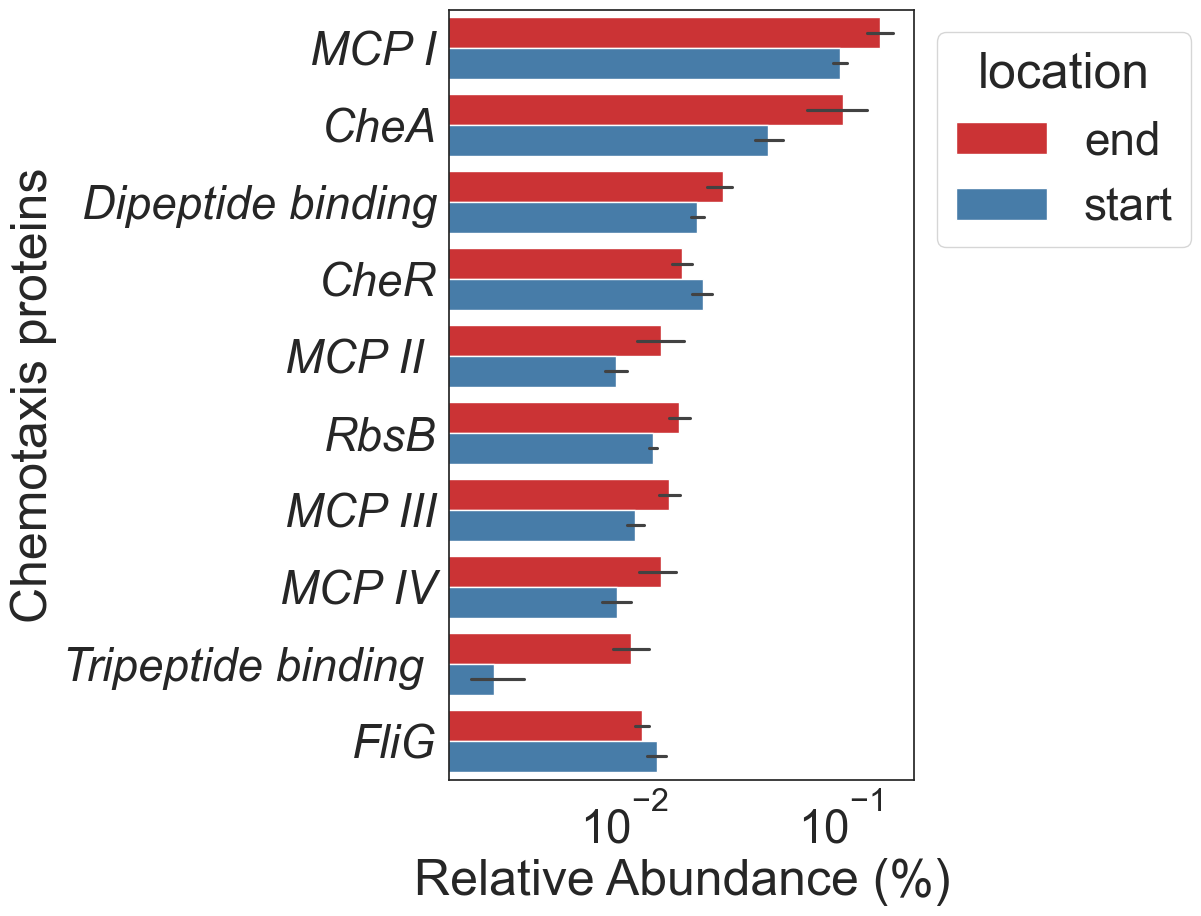

In [20]:
sns.set(rc={'figure.figsize':(6,10)}, font_scale=3, style = 'white')
# Custom colors for hue categories
palette = {'start': '#377eb8', 'end': '#e41a1c'}


ax = sns.barplot(data=chemotaxis_sig_functions.sort_values('log abundance', ascending = False), y = 'Function_n', hue = 'location', x = 0, palette=palette)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Relative Abundance (%)')
plt.ylabel('Chemotaxis proteins')
plt.xscale('log')
# Set x tick labels to italic
ax.set_yticklabels(ax.get_yticklabels(), fontstyle='italic')
plt.savefig('chemotaxis_barplot.png', bbox_inches='tight')

In [21]:
chemotaxis_sig_functions

Function_n     level_1         0 location tube  log abundance
22        CheR  FAME000002  0.014963      end   A1      -4.202165
23        CheR  FAME000004  0.018633      end   B1      -3.982802
24        CheR  FAME000006  0.020379      end   E1      -3.893263
25        CheR  FAME000009  0.017686      end   B2      -4.034967
26        CheR  FAME000011  0.023297      end   C2      -3.759423
..         ...         ...       ...      ...  ...            ...
341       CheA  FAME000014  0.046878    start   E2      -3.060203
342       CheA  FAME000016  0.050616    start   A3      -2.983495
343       CheA  FAME000018  0.047318    start   B3      -3.050874
344       CheA  FAME000020  0.045517    start   D3      -3.089678
345       CheA  FAME000022  0.039536    start   E3      -3.230545

[220 rows x 6 columns]

## Make Figure for the log-fold change in the functions 

In [25]:
deseq_level3 = pd.read_csv('../../Susie Data/deSeq_results_level3_subsystems.csv', index_col= 0)

In [26]:
lvl1_lvl3 = pd.read_csv('../../Susie Data/lvl1_lvl3_subsystems.tsv', sep = '\t', index_col = 0)
lvl1_lvl3_dict = dict(zip(lvl1_lvl3['Subsystem Level 3'], lvl1_lvl3['Subsystem Level 1']))

In [27]:
deseq_level3['lvl1'] = [lvl1_lvl3_dict.get(i) for i in deseq_level3.index.to_list()]

In [29]:
deseq_level3['lvl3'] = deseq_level3.index

increase = deseq_level3[deseq_level3['log2FoldChange'] > 0.5]
increase_sig = increase[increase['padj'] < 1e-15].sort_values('log2FoldChange', ascending = False)

decrease = deseq_level3[deseq_level3['log2FoldChange'] < -0.5]
decrease_sig = decrease[decrease['padj'] < 1e-15].sort_values('pvalue', ascending = True)

# Show the functions that increased in abundance during the migration

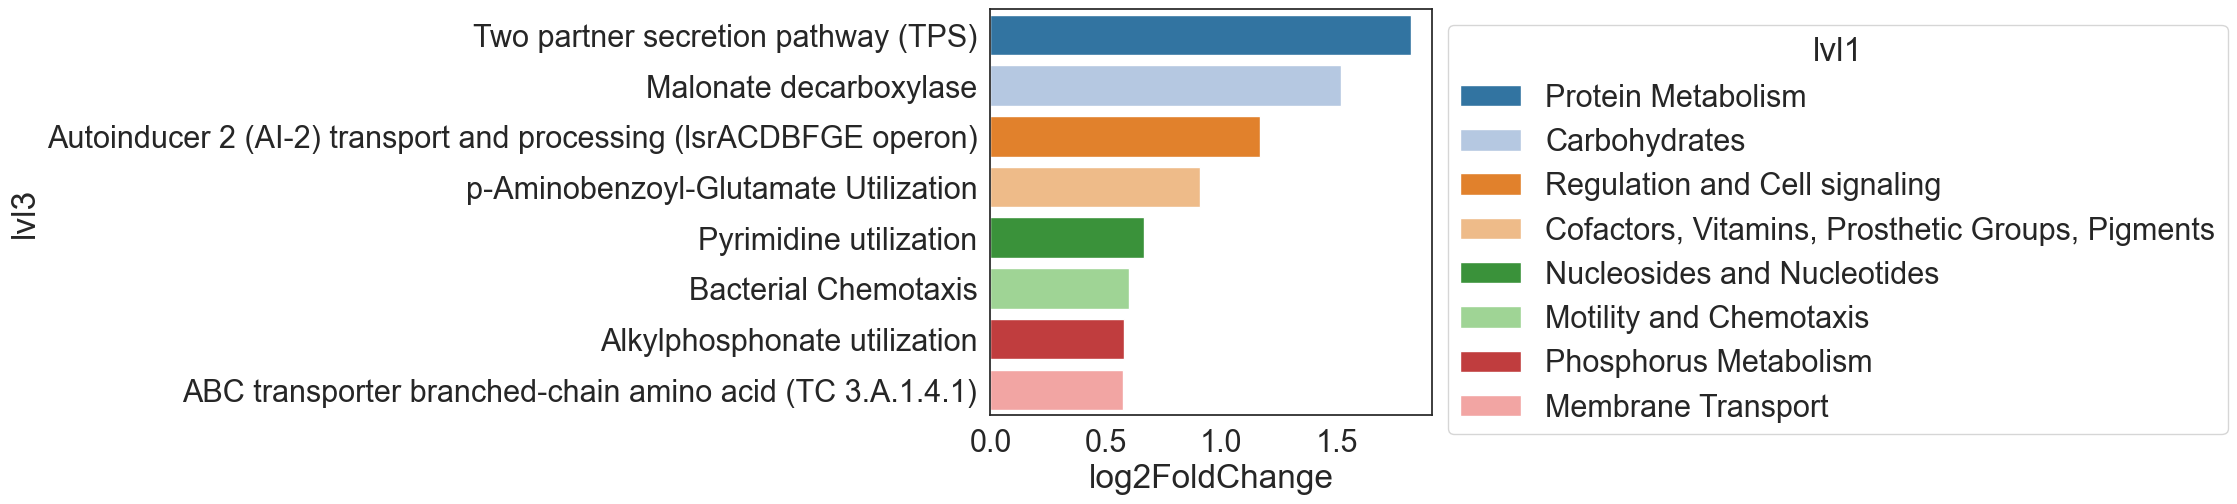

In [52]:
sns.set(rc={'figure.figsize':(5.7,5.27)}, font_scale=2, style = 'white')
ax = sns.barplot(increase_sig, x ='log2FoldChange', y = 'lvl3', hue = 'lvl1', palette = 'tab20')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Functions that decreased in abundance during migration

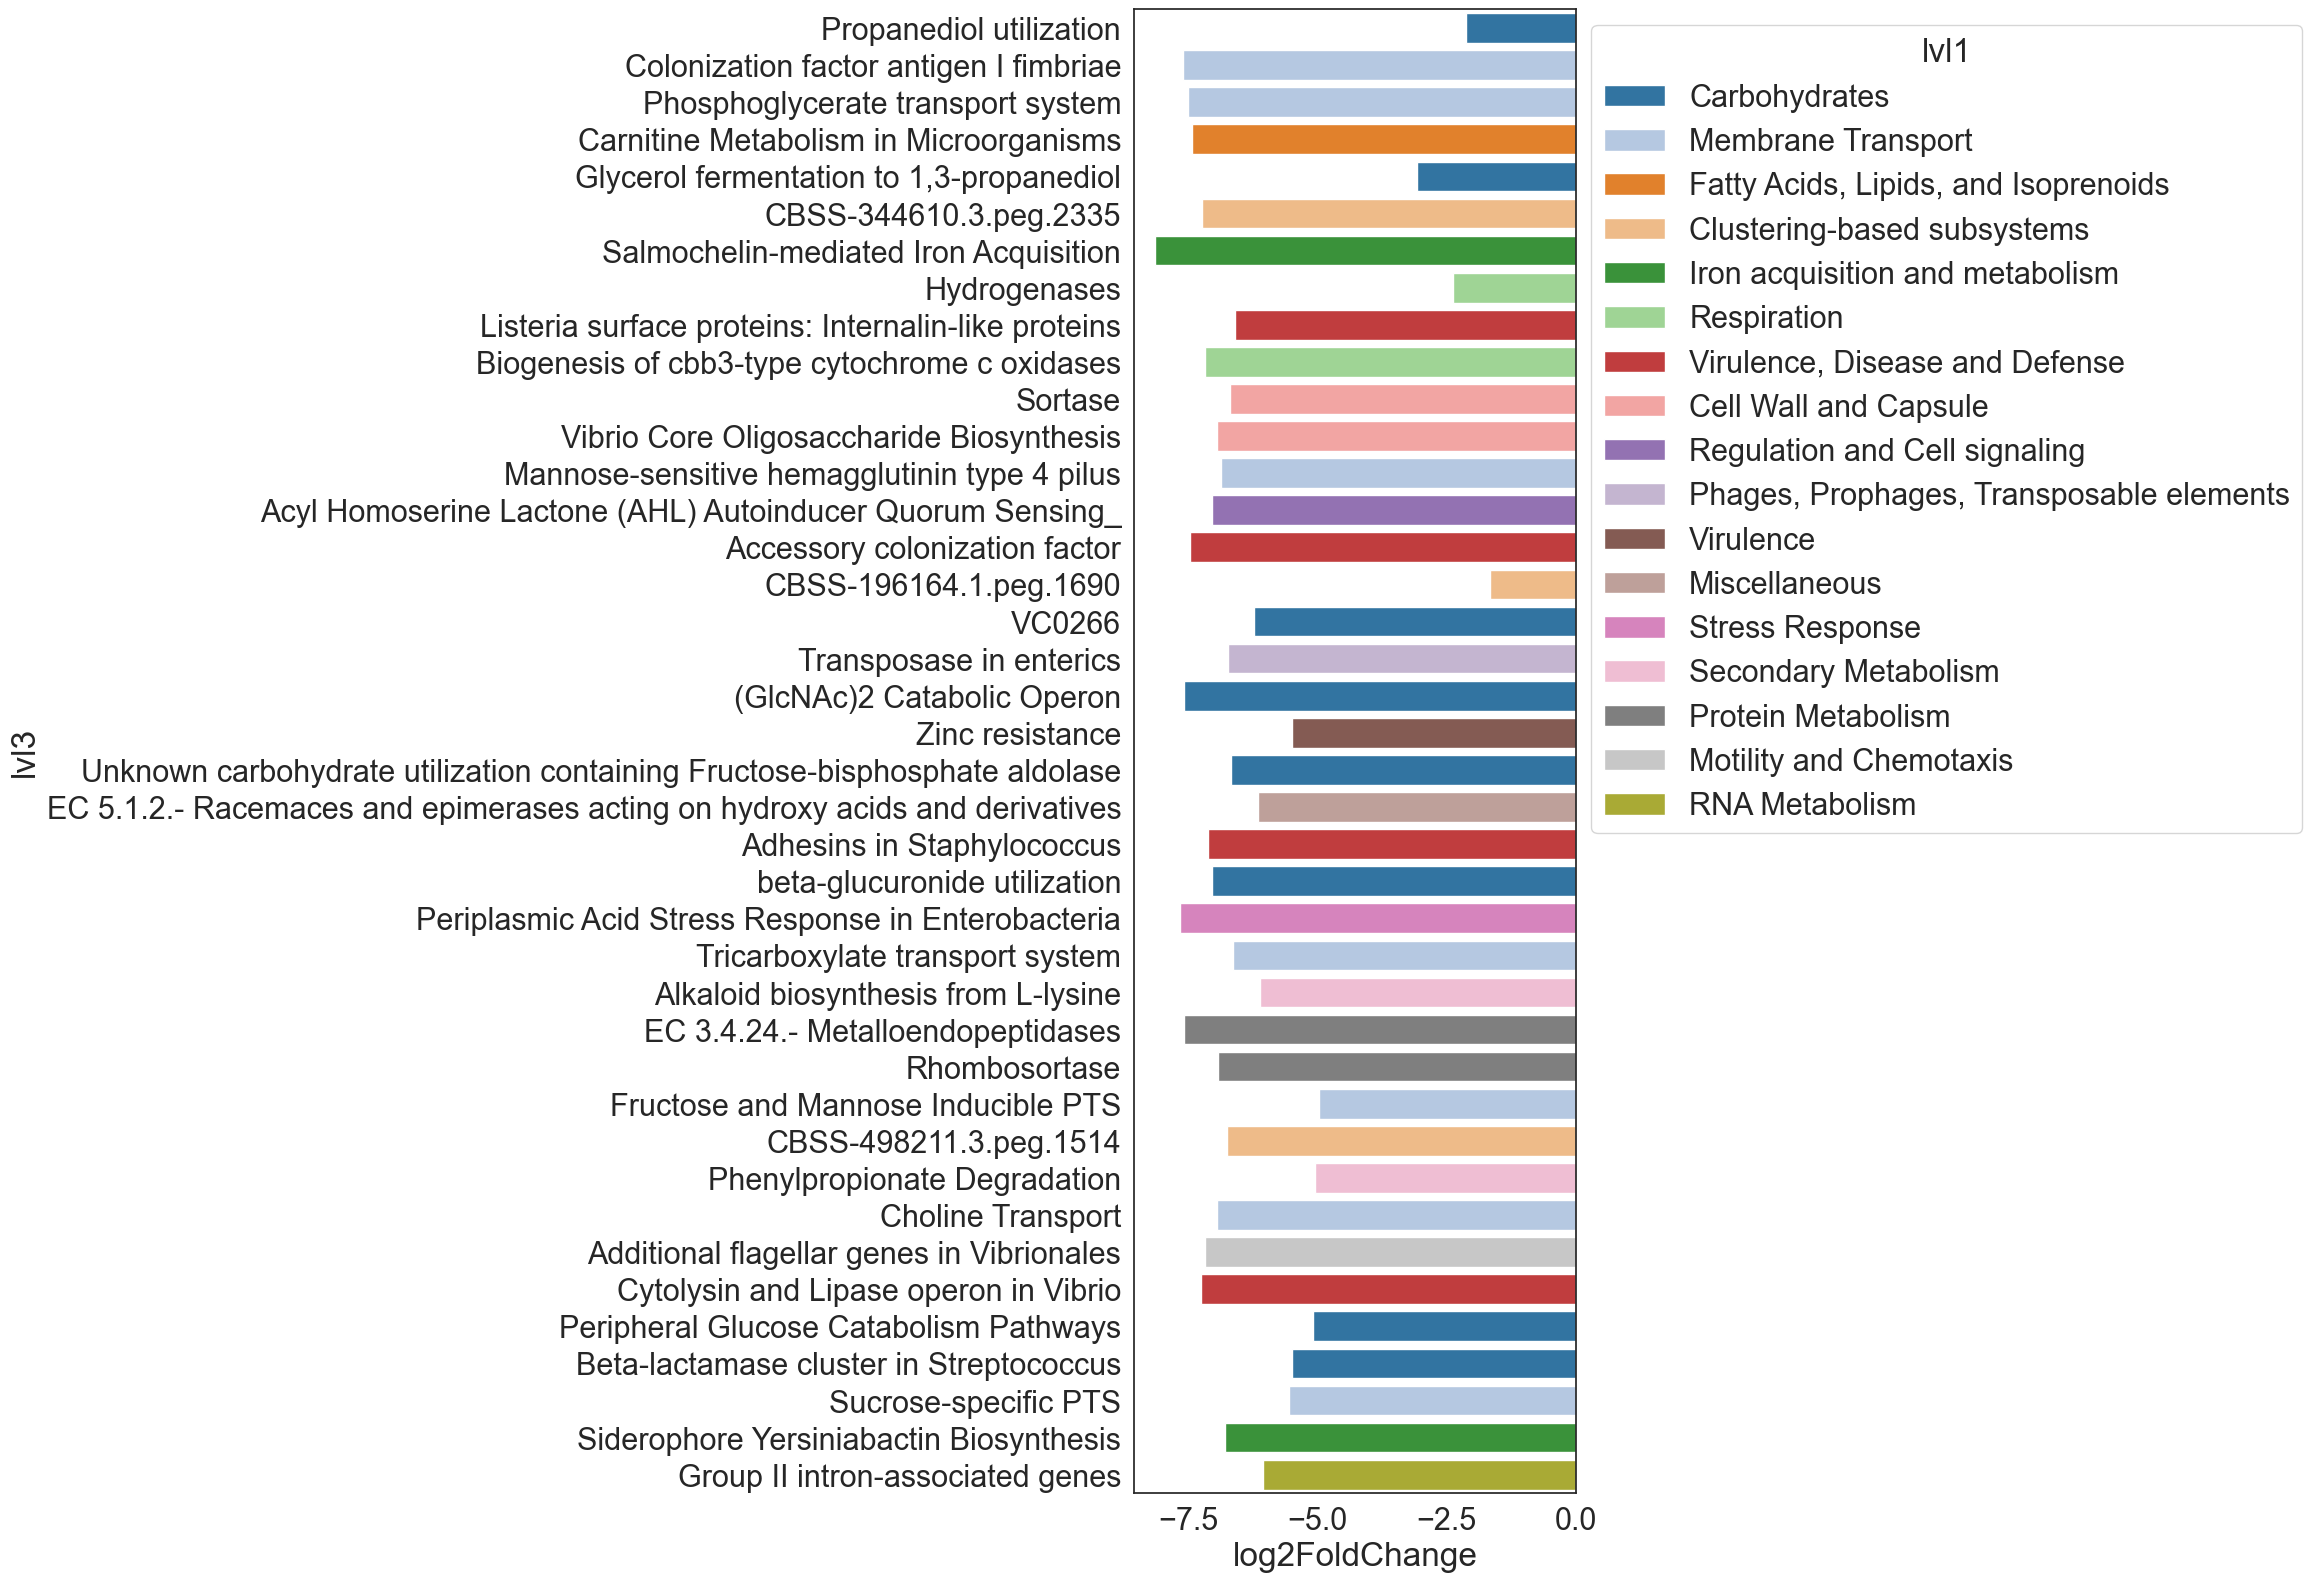

In [53]:
sns.set(rc={'figure.figsize':(5.7,19.27)}, font_scale=2, style = 'white')
ax = sns.barplot(decrease_sig.iloc[:40], x ='log2FoldChange', y = 'lvl3', hue = 'lvl1', palette = 'tab20')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [32]:
# what if we plot the abundance of the level 3 subsystems or their differences 
level3_subsystem = pd.read_csv('../../Susie Data/level3_readcounts.tsv', sep = '\t', index_col = 'Subsystem 3' )

In [33]:
level3_subsystem_abund = level3_subsystem*100/level3_subsystem.sum()
level3_subsystem_abund_stacked = pd.DataFrame(level3_subsystem_abund.stack()).reset_index() 

In [34]:
level3_subsystem_abund_stacked['sample'] = [re.split('_',i)[0] for i in level3_subsystem_abund_stacked['level_1']]
level3_subsystem_abund_stacked['location'] = [location_dict.get(i) for i in level3_subsystem_abund_stacked['sample']]
level3_subsystem_abund_stacked['Subsystem 1'] = [lvl1_lvl3_dict.get(i) for i in level3_subsystem_abund_stacked['Subsystem 3']] 

In [35]:
level3_subsystem_means = level3_subsystem_abund_stacked.drop(['Subsystem 1', 'level_1', 'sample'], axis=1).groupby(['Subsystem 3', 'location']).mean().reset_index()

In [36]:
#level3_subsystem_means['Subsystem 1'] = [lvl1_lvl3_dict.get(i) for i in level3_subsystem_means['Subsystem 3']]

In [37]:
level3_subsystem_means = level3_subsystem_abund_stacked.drop(['Subsystem 1', 'level_1', 'sample'], axis=1).groupby(['Subsystem 3', 'location']).mean().unstack(level='location').reset_index()

In [38]:
level3_subsystem_abund_stacked['tube'] = [tube_dict.get(i) for i in level3_subsystem_abund_stacked['sample']]
level3_subsystem_abund_stacked_start = level3_subsystem_abund_stacked[level3_subsystem_abund_stacked['location'] == 'start']
level3_subsystem_abund_stacked_end = level3_subsystem_abund_stacked[level3_subsystem_abund_stacked['location'] == 'end']

# something wrong with this merge that is creating more lines 
level3_subsystem_abund_stacked_diff = level3_subsystem_abund_stacked_start.merge(level3_subsystem_abund_stacked_end, how = 'outer', on = ['Subsystem 3', 'tube', 'Subsystem 1'], suffixes = ('_start', '_end'))
level3_subsystem_abund_stacked_diff['diff'] = level3_subsystem_abund_stacked_diff['0_end'] - level3_subsystem_abund_stacked_diff['0_start'] 
level3_subsystem_abund_stacked_diff['diff_abs'] = np.abs(level3_subsystem_abund_stacked_diff['diff'])


In [60]:
increase_plot_diff = level3_subsystem_abund_stacked_diff[level3_subsystem_abund_stacked_diff['Subsystem 3'].isin(increase_sig.index.to_list())]
decrease_plot_diff = level3_subsystem_abund_stacked_diff[level3_subsystem_abund_stacked_diff['Subsystem 3'].isin(decrease_sig.index.to_list())]
#increase_plot_diff['status'] = ['increase' for i in range(len(increase_plot_diff))]
#decrease_plot_diff['status'] = ['decrease' for i in range(len(decrease_plot_diff))]


plot_diff = pd.concat([increase_plot_diff, decrease_plot_diff])


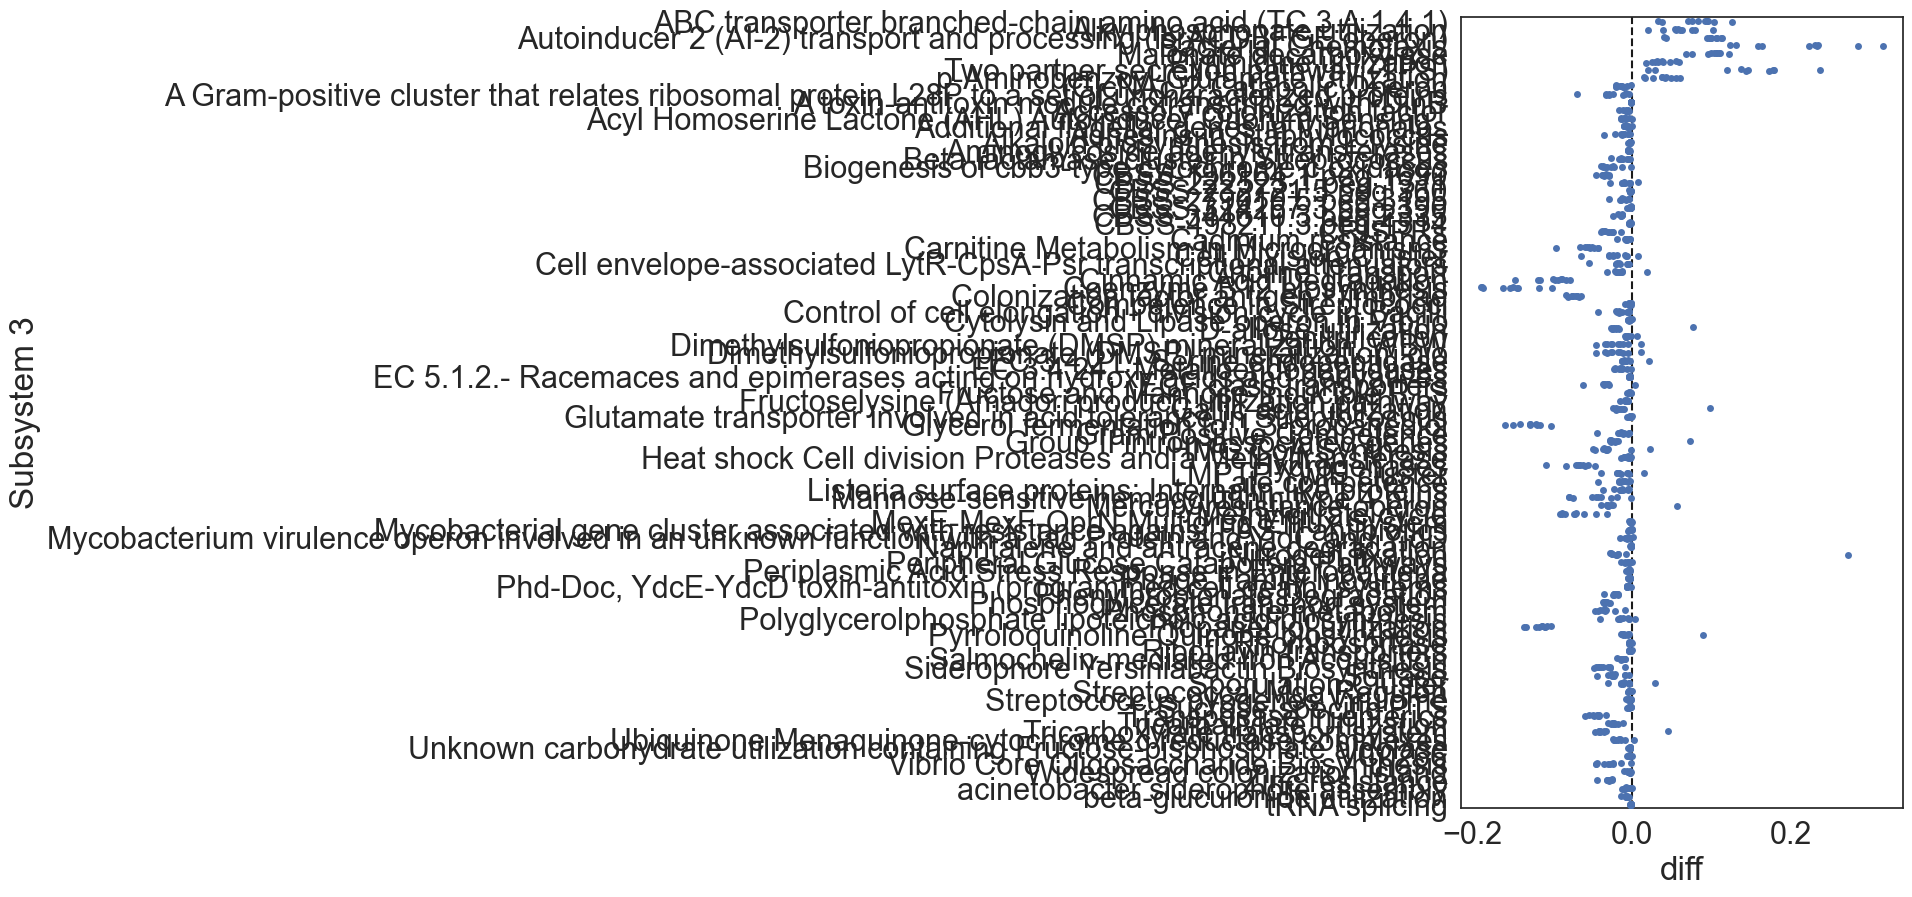

In [66]:
sns.set(rc={'figure.figsize':(5.7,10.27)}, font_scale=2, style = 'white')
ax = sns.stripplot(plot_diff, y = 'Subsystem 3', x = 'diff')
ax.axvline(x=0, color='k', linestyle='--')

In [67]:
# compute the means for each category
sig_subsystems = list(set(plot_diff['Subsystem 3']))

sig_means = [] 
for s in sig_subsystems: 
    mean = plot_diff[plot_diff['Subsystem 3'] == s]['diff'].mean()
    sig_means.append(mean) 

sig_subsystems_means = pd.DataFrame({'Subsystem 3': sig_subsystems, 'Mean': sig_means})
sig_subsystems_means['Mean_abs'] = np.abs(sig_subsystems_means['Mean'])
sig_subsystems_means = sig_subsystems_means.sort_values('Mean_abs', ascending = False)


In [68]:
plot_diff

Subsystem 3  \
240    ABC transporter branched-chain amino acid (TC ...   
241    ABC transporter branched-chain amino acid (TC ...   
242    ABC transporter branched-chain amino acid (TC ...   
243    ABC transporter branched-chain amino acid (TC ...   
244    ABC transporter branched-chain amino acid (TC ...   
...                                                  ...   
12691                                      tRNA splicing   
12692                                      tRNA splicing   
12693                                      tRNA splicing   
12694                                      tRNA splicing   
12695                                      tRNA splicing   

                      level_1_start   0_start sample_start location_start  \
240    FAME000001_good_out_R1.fastq  0.188049   FAME000001          start   
241    FAME000003_good_out_R1.fastq  0.204024   FAME000003          start   
242    FAME000005_good_out_R1.fastq  0.208428   FAME000005          start   
243    FAME000007_good_out_R1.fastq  0.254811   FAME000007          start   
244    FAME000008_good_out_R1.fastq  0.198910   FAME000008          start   
...                             ...       ...          ...            ...   
12691  FAME000014_good_out_R1.fastq  0.001290   FAME000014          start   
12692  FAME000016_good_out_R1.fastq  0.001409   FAME000016          start   
12693  FAME000018_good_out_R1.fastq  0.001165   FAME000018          start   
12694  FAME000020_good_out_R1.fastq  0.001587   FAME000020          start   
12695  FAME000022_good_out_R1.fastq  0.001237   FAME000022          start   

              Subsystem 1 tube                   level_1_end     0_end  \
240    Membrane Transport   A1  FAME000002_good_out_R1.fastq  0.279616   
241    Membrane Transport   B1  FAME000004_good_out_R1.fastq  0.298424   
242    Membrane Transport   E1  FAME000006_good_out_R1.fastq  0.246294   
243    Membrane Transport   A2                           NaN       NaN   
244    Membrane Transport   B2  FAME000009_good_out_R1.fastq  0.301967   
...                   ...  ...                           ...       ...   
12691      RNA Metabolism   E2  FAME000015_good_out_R1.fastq  0.000014   
12692      RNA Metabolism   A3  FAME000017_good_out_R1.fastq  0.000000   
12693      RNA Metabolism   B3  FAME000019_good_out_R1.fastq  0.000012   
12694      RNA Metabolism   D3                           NaN       NaN   
12695      RNA Metabolism   E3  FAME000023_good_out_R1.fastq  0.000000   

       sample_end location_end      diff  diff_abs    status  
240    FAME000002          end  0.091567  0.091567  increase  
241    FAME000004          end  0.094400  0.094400  increase  
242    FAME000006          end  0.037866  0.037866  increase  
243           NaN          NaN       NaN       NaN  decrease  
244    FAME000009          end  0.103056  0.103056  increase  
...           ...          ...       ...       ...       ...  
12691  FAME000015          end -0.001275  0.001275  decrease  
12692  FAME000017          end -0.001409  0.001409  decrease  
12693  FAME000019          end -0.001153  0.001153  decrease  
12694         NaN          NaN       NaN       NaN  decrease  
12695  FAME000023          end -0.001237  0.001237  decrease  

[1176 rows x 14 columns]

In [111]:
# color whether there was an overal increase or decrease 
plot_diff_mean = plot_diff.groupby('Subsystem 3').mean('diff')
plot_diff_mean['status'] = ['increase' if i > 0 else 'decrease' for i in plot_diff_mean['diff']]
plot_diff_status_dict = dict(zip(plot_diff_mean.index, plot_diff_mean['status'])) 
plot_diff_mean_dict = dict(zip(plot_diff_mean.index, plot_diff_mean['diff'])) 

/var/folders/df/d2hn3bdx7dj7syrpbrxgtzkw0000gn/T/ipykernel_6511/138127358.py:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(plot_diff, y = 'Subsystem 3', x = 'diff',  errorbar=('ci', 95), join=False, dodge= True,  markers='o', markersize=12, hue = 'status')


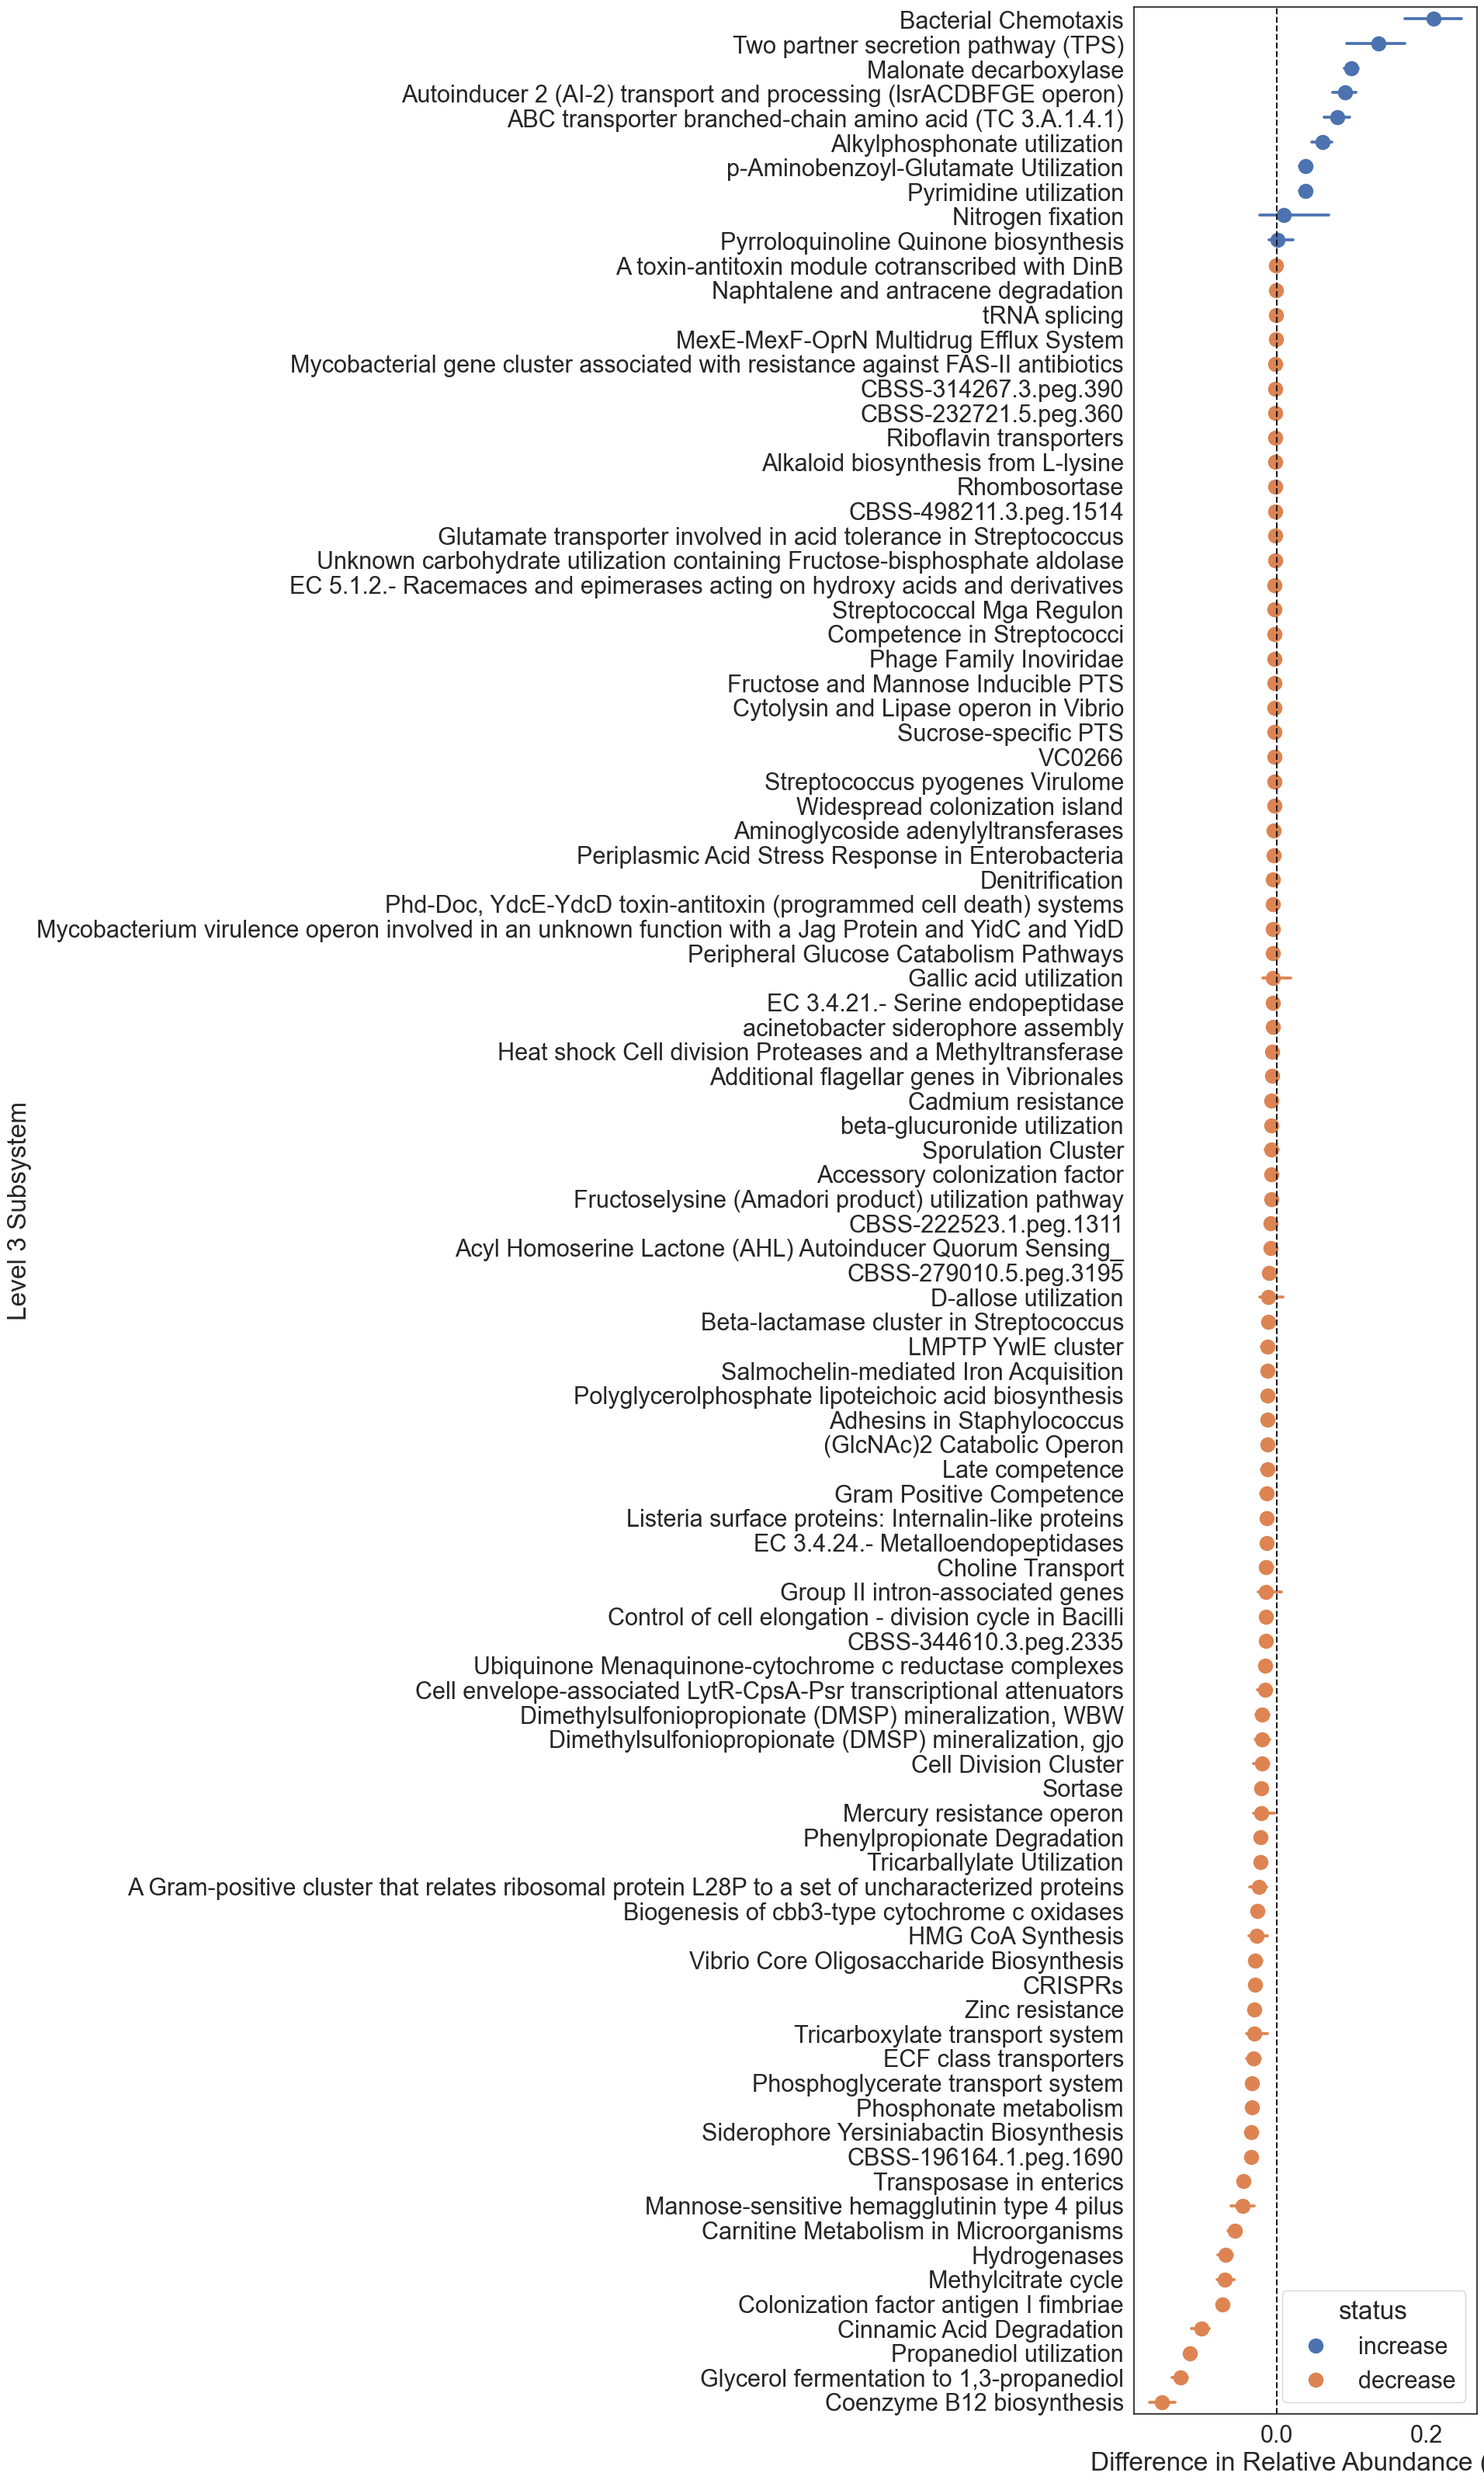

In [115]:
# add colors to the plots 
plot_diff['status'] = [plot_diff_status_dict.get(i) for i in  plot_diff['Subsystem 3']]
plot_diff['mean_diff'] = [plot_diff_mean_dict.get(i) for i in  plot_diff['Subsystem 3']]
plot_diff = plot_diff.sort_values('mean_diff', ascending = False)

sns.set(rc={'figure.figsize':(5.7,40.27)}, font_scale=2, style = 'white')
ax = sns.pointplot(plot_diff, y = 'Subsystem 3', x = 'diff',  errorbar=('ci', 95), join=False, dodge= True,  markers='o', markersize=12, hue = 'status')
ax.axvline(x=0, color='k', linestyle='--')
plt.ylabel('Level 3 Subsystem')
plt.xlabel('Difference in Relative Abundance (%)')
plt.savefig('differentlyexprseed_level3subsystems_difference.png', bbox_inches = 'tight')

/var/folders/df/d2hn3bdx7dj7syrpbrxgtzkw0000gn/T/ipykernel_6511/2450361877.py:3: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(plot_diff_top10, y = 'Subsystem 3', x = 'diff',  errorbar=('ci', 95), join=False, dodge= True,  markers='o', markersize=12, hue = 'status')


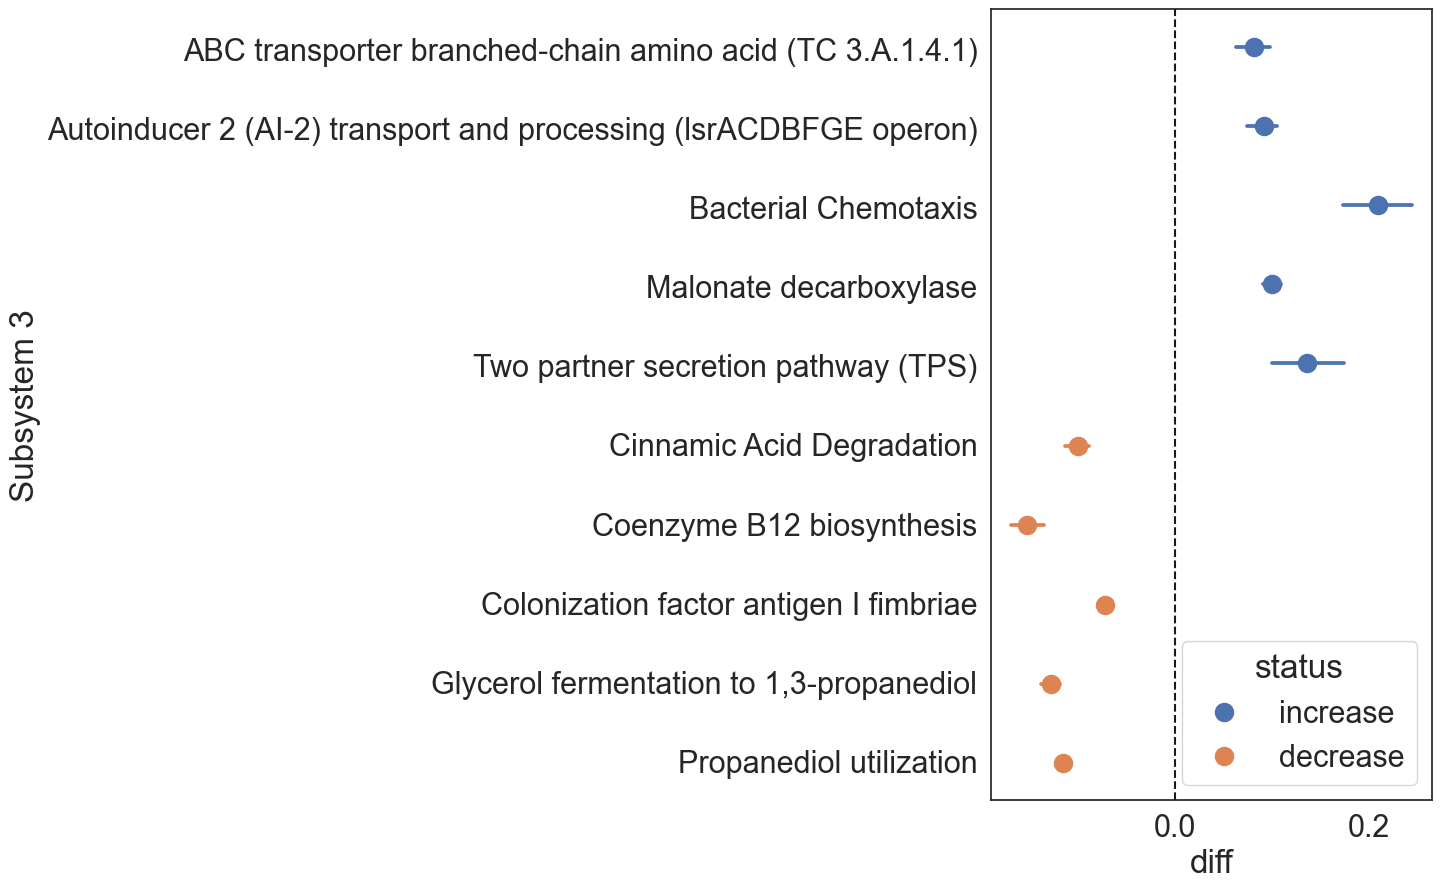

In [70]:
plot_diff_top10 = plot_diff[plot_diff['Subsystem 3'].isin(sig_subsystems_means.iloc[:10]['Subsystem 3'].to_list()) ]
sns.set(rc={'figure.figsize':(5.7,10.27)}, font_scale=2, style = 'white')
ax = sns.pointplot(plot_diff_top10, y = 'Subsystem 3', x = 'diff',  errorbar=('ci', 95), join=False, dodge= True,  markers='o', markersize=12, hue = 'status')
ax.axvline(x=0, color='k', linestyle='--')
plt.savefig('differentlyexprseed_level3subsystems_difference.png')

In [46]:
# take names to update the figure 
names_dict = {'ABC transporter branched-chain amino acid (TC 3.A.1.4.1)': 'Polypeptide transport',
 'Bacterial Chemotaxis': 'Bacterial Chemotaxis',
 'Carnitine Metabolism in Microorganisms': 'Carnitine Metabolism', 
 'Colonization factor antigen I fimbriae': 'Fimbriae colonization factor' ,
 'Malonate decarboxylase': 'Malonate decarboxylase',
 'Two partner secretion pathway (TPS)': 'Two partner secretion pathway',
 'p-Aminobenzoyl-Glutamate Utilization': 'p-Aminobenzoyl-Glutamate Utilization',
 'CBSS-196164.1.peg.1690': 'Iron-sulfur cluster',
 'Coenzyme B12 biosynthesis': 'Coenzyme B12 biosynthesis',
 'Hydrogenases': 'Hydrogenases',
 'Pyrimidine utilization': 'Pyrimidine utilization',
 'Autoinducer 2 (AI-2) transport and processing (lsrACDBFGE operon)': 'Autoinducer transport',
 'Glycerol fermentation to 1,3-propanediol': 'Glycerol fermentation',
 'Mannose-sensitive hemagglutinin type 4 pilus' : 'Mannose-sensitive pilus',
 'Siderophore Yersiniabactin Biosynthesis' : 'Yersiniabactin Biosynthesis',
 'Transposase in enterics': 'Transposase in enterics',
 'Alkylphosphonate utilization': 'Alkylphosphonate utilization',
 'Methylcitrate cycle': 'Methylcitrate cycle',
 'Cinnamic Acid Degradation': 'Cinnamic Acid Degradation',
 'Propanediol utilization': 'Propanediol utilization'}

/var/folders/df/d2hn3bdx7dj7syrpbrxgtzkw0000gn/T/ipykernel_6511/3111418837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_diff_top10['nickname'] = [names_dict.get(i) for i in plot_diff_top10['Subsystem 3']]


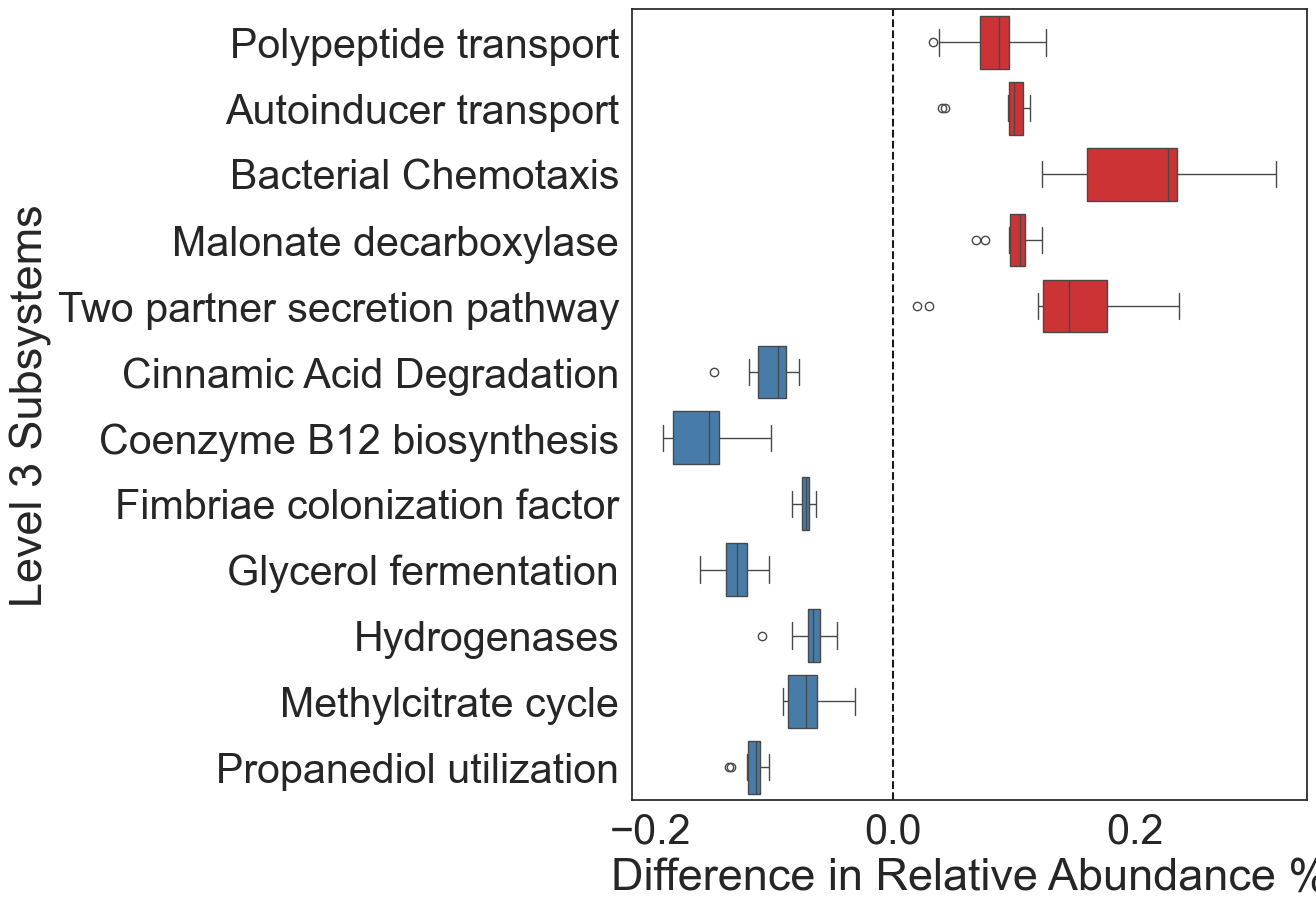

In [47]:
# Filter data
plot_diff_top10 = plot_diff[plot_diff['Subsystem 3'].isin(sig_subsystems_means.iloc[:12]['Subsystem 3'].tolist())]
plot_diff_top10['nickname'] = [names_dict.get(i) for i in plot_diff_top10['Subsystem 3']]

# Define red and blue palette
palette = {'decrease': '#377eb8', 'increase': '#e41a1c'}

sns.set(rc={'figure.figsize': (8.7, 10.27)}, font_scale=2.7, style='white')
ax = sns.boxplot(data=plot_diff_top10, y='nickname', x='diff', hue='status', palette=palette, legend=False)
ax.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Difference in Relative Abundance %')
plt.ylabel('Level 3 Subsystems')
plt.savefig('differentlyexprseed_level3subsystems_difference.png', bbox_inches='tight')
plt.show()

/var/folders/df/d2hn3bdx7dj7syrpbrxgtzkw0000gn/T/ipykernel_6511/1115846568.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_diff_top10['nickname'] = [names_dict.get(i) for i in plot_diff_top10['Subsystem 3']]


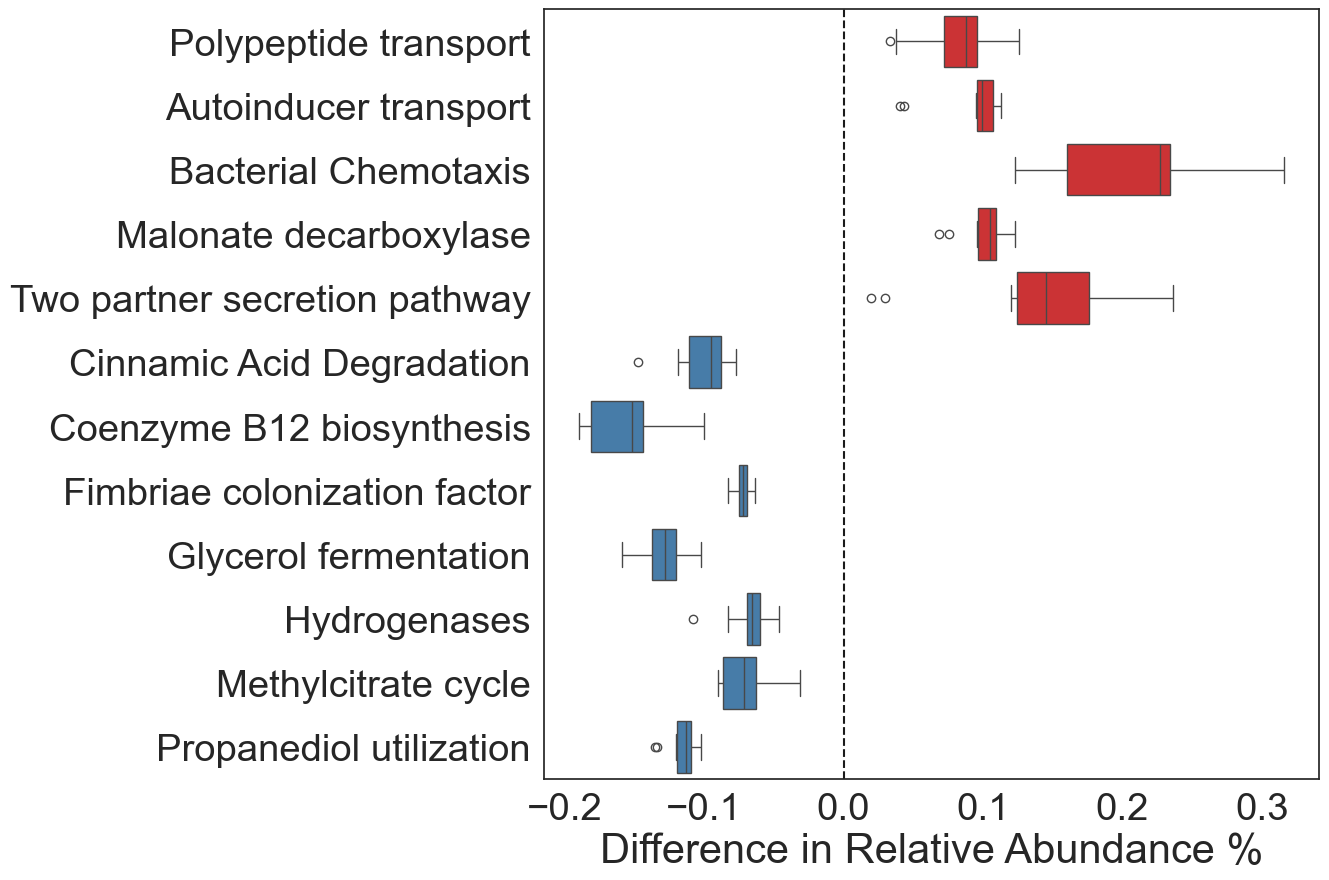

In [48]:
# Filter data
sns.set(rc={'figure.figsize':(10,10)}, font_scale=2.5, style = 'white')
plot_diff_top10 = plot_diff[plot_diff['Subsystem 3'].isin(sig_subsystems_means.iloc[:12]['Subsystem 3'].tolist())]
plot_diff_top10['nickname'] = [names_dict.get(i) for i in plot_diff_top10['Subsystem 3']]

# Define red and blue palette
palette_colors = {"increase": "#e41a1c", "decrease": "#377eb8"}

#sns.set(rc={'figure.figsize': (8.7, 10.27)}, font_scale=2, style='white')
ax = sns.boxplot(data=plot_diff_top10, y='nickname', x='diff', hue='status', palette=palette, legend=False)
ax.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Difference in Relative Abundance %')
plt.ylabel('')
plt.savefig('differentlyexprseed_level3subsystems_difference.png')
plt.show()